#### 合并人工AI数据集加上标签

In [18]:
import pandas as pd  
import numpy as np

# 文件路径  
ai_file = '../results/generated_reviews.txt'  # AI生成的评论文件  
human_file = "../data(temp)/unique_comments.txt" # 人工生成的评论文件  

# 初始化列表来存储评论和标签  
comments = []  
labels = []  

# 读取AI生成的评论  
with open(ai_file, 'r', encoding='utf-8') as f:  
    for line in f:  
        comments.append(line.strip())  # 移除首尾空白字符  
        labels.append("AI")   

# 读取人工生成的评论  
with open(human_file, 'r', encoding='utf-8') as f:  
    for line in f:  
        comments.append(line.strip())  # 移除首尾空白字符  
        labels.append("Human")  

# 创建DataFrame  
data = pd.DataFrame({  
    'comment': comments,  
    'label': labels  
})  

# 保存为CSV文件  
data.to_csv('../results/review_labeled.csv', index=False, encoding='utf-8')  

### 特征提取

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer  
from scipy.sparse import hstack  

In [20]:
# 读取数据集  
df = pd.read_csv('../results/review_labeled.csv')  
print(df.shape)
df.head()


(5810, 2)


,comment,label
0,有去屑效果不错。,AI
1,效果出乎意料的好。,AI
2,这款洗发水去油力还是很不错的。,AI
3,香味也很好味。,AI
4,现在头发清爽蓬松了😇洗完头发很香。,AI


In [21]:
df.label.value_counts()

label
Human    5248
AI        562
Name: count, dtype: int64

In [22]:
# 提取标签  
y = df['label'].values  

#### 提取评论长度特征

In [23]:
# 提取评论长度特征  
df['评论长度'] = df['comment'].apply(len)  
X_length = df['评论长度'].values.reshape(-1, 1)  
X_length[:5]

array([[ 8],
       [ 9],
       [15],
       [ 7],
       [17]], dtype=int64)

In [24]:
X_length.shape

(5810, 1)

#### 提取情感特征

In [25]:
from snownlp import SnowNLP
from snownlp import sentiment
X_sentiment=[]
for review in df['comment']:
    X_sentiment.append(SnowNLP(review).sentiments)
X_sentiment=np.array([X_sentiment]).reshape(-1,1)
X_sentiment

array([[0.89510894],
       [0.95054448],
       [0.94951706],
       ...,
       [0.14661936],
       [0.31366405],
       [0.28368982]])

#### doc2vec模型评论向量化

In [26]:
import gensim
import re
import jieba
import numpy
from random import shuffle
import csv
from gensim.models.doc2vec import Doc2Vec
TaggededDocument = gensim.models.doc2vec.TaggedDocument
jieba.setLogLevel(jieba.logging.INFO)

#清洗评论
def CleanReview(reviews):
    corpus=[]
    documents=[]
    sens=[]
    for i,each in enumerate(reviews):
        cut=jieba.lcut(each)
        text2=[]
        for word in cut:
            word=re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", word)#去除标点
            if word=='':#去除空字符
                continue
            text2.append(word)
        sens.append(text2)
        document = TaggededDocument(text2, tags=[i])
        corpus.append(document)
    return corpus,sens
#向量化
def doc2vec(corpus,sens):
    model_dm = Doc2Vec(corpus, min_count=10, window=5, vector_size=5, sample=1e-3, negative=5, workers=4, dm=1)
    model_dm.train(corpus, total_examples=model_dm.corpus_count, epochs=7)
    vecs=[]
    for review in sens:
        vecs.append(list(model_dm.infer_vector(review)))
    #print(vecs[0:5])
    return vecs

In [27]:
corpus,sens=CleanReview(df['comment'])
Vecs=doc2vec(corpus,sens)
Vecs[:5]

[[-0.12752274, 0.11628099, 0.22830112, -0.18975261, -0.16636792],
 [0.025836684, 0.1449949, 0.1828782, -0.15542218, -0.053922012],
 [-0.045734104, -0.07316635, 0.07131091, -0.20920639, 0.036670204],
 [-0.15878037, 0.050874963, 0.04367473, -0.07818805, 0.037930083],
 [0.0054226303, -0.065615356, -0.03716296, -0.052784067, 0.08632608]]

In [28]:
X_Vecs=np.array(Vecs)
X_Vecs.shape

(5810, 5)

#### 合并特征

In [29]:
X =np.hstack((X_Vecs,X_length,X_sentiment))
X[:5]

array([[-1.27522737e-01,  1.16280988e-01,  2.28301123e-01,
        -1.89752609e-01, -1.66367918e-01,  8.00000000e+00,
         8.95108942e-01],
       [ 2.58366838e-02,  1.44994900e-01,  1.82878196e-01,
        -1.55422181e-01, -5.39220124e-02,  9.00000000e+00,
         9.50544476e-01],
       [-4.57341038e-02, -7.31663480e-02,  7.13109076e-02,
        -2.09206387e-01,  3.66702043e-02,  1.50000000e+01,
         9.49517061e-01],
       [-1.58780366e-01,  5.08749634e-02,  4.36747298e-02,
        -7.81880468e-02,  3.79300825e-02,  7.00000000e+00,
         9.48379958e-01],
       [ 5.42263035e-03, -6.56153560e-02, -3.71629596e-02,
        -5.27840666e-02,  8.63260776e-02,  1.70000000e+01,
         2.69619373e-01]])

#### 降维可视化数据

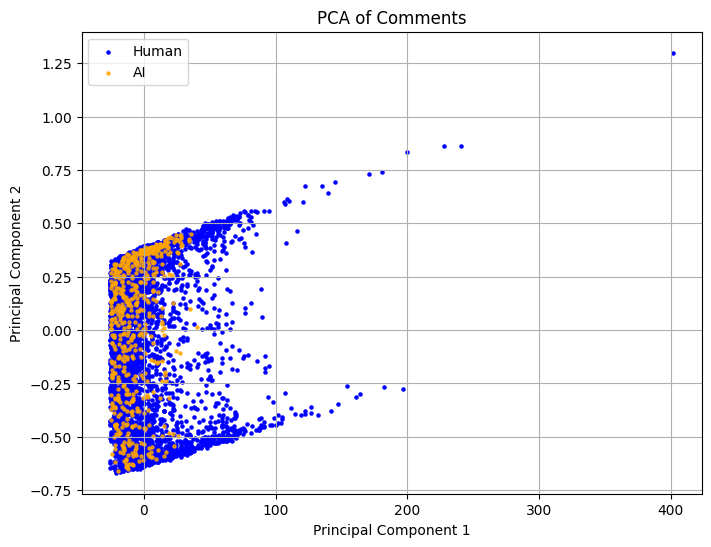

In [30]:
import numpy as np  
import pandas as pd  
from sklearn.decomposition import PCA  
import matplotlib.pyplot as plt  
  
# 使用 PCA 降维到 2 维  
pca = PCA(n_components=2)  
X_reduced = pca.fit_transform(X)  

# 假设 y 里面有 0 和 1 两种类别  
# 绘制散点图  
plt.figure(figsize=(8, 6))  
plt.scatter(X_reduced[y == "Human", 0], X_reduced[y == "Human", 1], label='Human', color='blue', alpha=1,s=5)  
plt.scatter(X_reduced[y == "AI", 0], X_reduced[y == "AI", 1], label='AI', color='orange', alpha=0.8,s=5)  

plt.title('PCA of Comments')  
plt.xlabel('Principal Component 1')  
plt.ylabel('Principal Component 2')  
plt.legend()  
plt.grid()  
plt.show() 

#### 保存数据

In [31]:
import csv  
# 将数据写入CSV文件  
with open('../results/review_featured.csv', 'w', newline='', encoding='utf-8') as csvfile:  
    writer = csv.writer(csvfile)  
    writer.writerow(['vec1','vec2','vec3','vec4','vec5','length','sentiment','label'])  # 写入表头  
    for i,x in enumerate(X):  
        x1=list(x)
        x1.append(y[i])
        writer.writerow(x1)  